In [10]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm, rc
fr
om scipy.stats import truncnorm
import os 

# %matplotlib inline
%matplotlib notebook
# from ipywidgets import interactive, interact

# Add latex fonts if availabe (may need to change path of latex install)
if os.path.isdir("/usr/local/texlive/2020/bin"):
    os.environ["PATH"] += os.pathsep + '/usr/local/texlive/2020/bin/x86_64-darwin'
    rc('text', usetex='True')
    rc('font', family='serif', serif = 'Helvetica')
    params= {'text.latex.preamble' : [r'\usepackage{amsfonts}']}
    plt.rcParams.update(params)
    
if not os.path.exists('./plots'):
    os.makedirs('./plots')

SyntaxError: invalid syntax (<ipython-input-10-a085f5947d5b>, line 5)

Consider a charging facility offering $L$ service levels where the total cost to a user from choosing a service level $\ell$ is 
$$g_\ell(x_j, \alpha_j) = x_j V^\ell + \alpha_j \frac{x_j}{R^\ell}.$$

where $x_j \sim f_X(x_j)$ and $\alpha_j \sim p_A(\alpha_j; p,a)$. We are interested in the quantity $$ \mathbb{E}[\eta(t);p,a] = \lambda \mathbb{E}[x] \mathbb{E}[\frac{1}{r};p,a]$$ and its sensitivity to the mischaracterization of $\alpha_j$. 

In the next block, for each service level $\ell \in \{1, \dots, L\}$ we must set the charging rates and their prices. Additionally, we set $f_X(x_j) = \mathcal{U}(x_\text{min}, x_\text{max})$ and compute $\mathbb{E}[x]$. 


In [11]:
lambda_val = 30 # EVs/ hr
x_min = 5
x_max = 100
E_x = (x_max**2 - x_min**2)/(2 * (x_max - x_min)) #expected value of demand x_j (kwh)
R_ell_A = np.array([15, 30 , 35])
V_ell_A = np.array([.15, .25, .32])

R_ell_B = np.array([15, 30 , 35])
V_ell_B = np.array([.05, .25, .33])

Given that $\alpha_j$ is a discrete random variable it has a PMF $p_A(\alpha_j)$ such that
$$p_A(\alpha_j) = \begin{cases} 
                  p_1 \quad \alpha_j = a_1 \\
                  \vdots \\
                  p_M \quad \alpha_j = a_M.
                  \end{cases} $$
In the next block we define $a$ and $p$. 
## You can customize $a$ and $p$ here to see effect on expected number of users

In [12]:
# PMF of alpha 
num_bins = 4
alpha_pmf_val_est = np.array([2, 10, 20, 25]) # a vector
alpha_pmf_wt_est = np.ones(num_bins)/num_bins # p vector
# alpha_pmf_wt = np.array([1/3, 1/3, 1/3]) # p vector

# Estimated 
alpha_pmf_val = np.array([2, 5.5, 20, 25]) # a vector
alpha_pmf_wt  = np.ones(num_bins)/num_bins # p vector

Next, we build a matrix that gives the ratio $$\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} $$ 
where $\Delta^i_k V = V^i - V^k$, and $\Delta^k_i \bar{R} = \frac{1}{R^k} - \frac{1}{R^i}$. This ratio is important for finding probability a user will choose a specific charging rate. Specifically, the PMF of the charge rates 
$$\renewcommand{\P}{\mathbb{P}}
p_{r}(r) = 
        \begin{cases}       
            \P \left(\underline{\alpha}^1 < \alpha_j < \bar{\alpha}^1 \right) & \text{if } r = R^1 \,, \\ 
            \qquad \quad  \vdots &  \\
            \P \left(\underline{\alpha}^L < \alpha_j < \bar{\alpha}^L \right) & \text{if } r = R^L \,.
        \end{cases} 
$$
where $\underline{\alpha}^1 = -\infty$ and $\bar{\alpha}^L = +\infty$ and otherwise $$\underline{\alpha}^k =  \max_{i<k}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}} $$ and $$ \bar{\alpha}^k = \min_{k < i}\frac{\Delta^i_k V}{\Delta^k_i \bar{R}}.$$ The next block prints out the ratio mentioned above in matrix format where each row is $k$ and each column is the index $i$. 

In [13]:
# Compute Delta Ratio 
def compute_delVdelR(R_ell, V_ell):
    delR = np.vstack((R_ell, R_ell))
    delV = np.vstack((V_ell, V_ell))

    for _ in range(0, R_ell.size - 2):
        delR = np.vstack((delR, R_ell))
        delV = np.vstack((delV, V_ell))

    delR = delR.astype('float')
    delR[delR==0] = np.nan

    delR = np.divide(1,delR) - np.divide(1, delR.T) 
    delV = delV.T - delV

    # print(delR, '\n', delV)
    delVdelR = np.divide(delV, delR)
    
    return delVdelR

delVdelR_A = compute_delVdelR(R_ell_A, V_ell_A)
delVdelR_B = compute_delVdelR(R_ell_B, V_ell_B)

print("The ratio matrix where the row is k and the column is i is: \n", delVdelR_A)
print("The ratio matrix where the row is k and the column is i is: \n", delVdelR_B)

The ratio matrix where the row is k and the column is i is: 
 [[    nan  3.      4.4625]
 [ 3.         nan 14.7   ]
 [ 4.4625 14.7        nan]]
The ratio matrix where the row is k and the column is i is: 
 [[  nan  6.    7.35]
 [ 6.     nan 16.8 ]
 [ 7.35 16.8    nan]]


<ipython-input-13-86f0c3dd1d3c>:17: RuntimeWarning: invalid value encountered in true_divide
  delVdelR = np.divide(delV, delR)


Define a function that computes the probability of of choosing a particular rate given a set of parameters, i.e., a vectorized version of the PMF $p_r(r)$.

In [5]:
def prob_choice(delVdelR, alpha_pmf_val, alpha_pmf_wt, R_ell, V_ell):
    # Get min and max values
    int_bounds = [[], []]
    alpha_min = -np.inf
    alpha_max = np.inf
    prob_choosing_R = np.zeros((delVdelR.shape[0],1))
    for i in range(0, R_ell.size):
        if i == 0:
            lower = alpha_min
            upper = np.nanmin(delVdelR[i+1:])
#             print(lower, "\t", upper)
        elif i == R_ell.size - 1:
            lower = np.nanmax(delVdelR[:i])
            upper = alpha_max
#             print(lower, "\t", upper)
        else:
            lower = np.maximum(alpha_min, np.nanmax(delVdelR[i][:i]))
            upper = np.minimum(alpha_max, np.nanmin(delVdelR[i][i+1:]))
            
# Save values of lower bounds 
        if upper - lower > 1e-6:
            int_bounds[0].append(lower)
            int_bounds[1].append(upper)
        
#         print(lower, "\t\t\t",upper)
        idx = (alpha_pmf_val >= lower) & (alpha_pmf_val <= upper)
    #     print(np.where(idx)[0])
        idx = np.where(idx)
        if idx[0].size > 0:
#             print("size", idx[0].size)
            for j in range(0, idx[0].size):
                prob_choosing_R[i] += alpha_pmf_wt[idx[0][j]]
    return prob_choosing_R, int_bounds

Define a function that computes $\mathbb{E}[\frac{1}{r};p,a]$. 

In [6]:
def compute_exp_1_r(prob_choosing_R, R_ell):
    E_1_r = 0
    for i in range(0, R_ell.size):
        E_1_r += prob_choosing_R[i] * (1/R_ell[i])
    
    return E_1_r

Prob choice A real: 
 [[0.25]
 [0.25]
 [0.5 ]] 
Prob choice A est:
  [[0.25]
 [0.25]
 [0.5 ]]
Prob choice B real: 
 [[0.5]
 [0. ]
 [0.5]] 
Prob choice B est:
 [[0.25]
 [0.25]
 [0.5 ]]
Percent Error from Pricing A:  [0.] 	Percent Error from Pricing B:  [0.175]
Est. Pricing A:  [61.875] 	 Est. Pricing B:  [61.875]
Pricing A:  [61.875] 	 Pricing B:  [75.]
Error from Pricing A:  [0.] 	 Error from Pricing B:  [13.125]


<IPython.core.display.Javascript object>


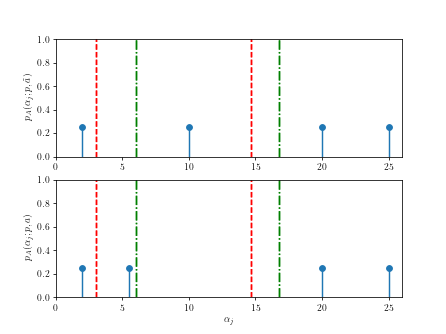

In [7]:
p_c_A, int_bds_A = prob_choice(delVdelR_A, alpha_pmf_val, alpha_pmf_wt, R_ell_A, V_ell_A)
p_c_A_est, _ = prob_choice(delVdelR_A, alpha_pmf_val_est, alpha_pmf_wt_est, R_ell_A, V_ell_A)

p_c_B, int_bds_B = prob_choice(delVdelR_B, alpha_pmf_val, alpha_pmf_wt, R_ell_B, V_ell_B)
p_c_B_est, _ = prob_choice(delVdelR_B, alpha_pmf_val_est, alpha_pmf_wt_est, R_ell_B, V_ell_B)

print("Prob choice A real: \n", p_c_A,"\nProb choice A est:\n ", p_c_A_est)
print("Prob choice B real: \n", p_c_B,"\nProb choice B est:\n", p_c_B_est)

exp1r_A = compute_exp_1_r(p_c_A, R_ell_A)
exp1r_A_est = compute_exp_1_r(p_c_A_est, R_ell_A)

exp1r_B = compute_exp_1_r(p_c_B, R_ell_B)
exp1r_B_est = compute_exp_1_r(p_c_B_est, R_ell_B)

exp_eta_A_err = lambda_val*E_x*(exp1r_A - exp1r_A_est)/(lambda_val*E_x*exp1r_A)
exp_eta_B_err = lambda_val*E_x*(exp1r_B - exp1r_B_est)/(lambda_val*E_x*exp1r_B)


print("Percent Error from Pricing A: ", exp_eta_A_err, "\tPercent Error from Pricing B: ",  exp_eta_B_err)
print("Est. Pricing A: ", lambda_val*E_x*exp1r_A_est, 
              "\t Est. Pricing B: ",  lambda_val*E_x*exp1r_B_est)
print("Pricing A: ", lambda_val*E_x*exp1r_A, 
              "\t Pricing B: ",  lambda_val*E_x*exp1r_B)
print("Error from Pricing A: ", lambda_val*E_x*(exp1r_A - exp1r_A_est), 
              "\t Error from Pricing B: ",  lambda_val*E_x*(exp1r_B - exp1r_B_est))

fig, ax = plt.subplots(2,1)
ax[0].stem(alpha_pmf_val_est, alpha_pmf_wt_est, basefmt=" ")
ax[0].set_ylim([0,1])
for i in range(0,2): # Loop through number of pricing sets
    for j in range(0, len(int_bds_A[i])):
        ax[0].axvline(int_bds_A[i][j], color='r',linestyle='--')
        
    for j in range(0, len(int_bds_B[i])):
        ax[0].axvline(int_bds_B[i][j], color='g',linestyle='-.')
        
ax[1].stem(alpha_pmf_val, alpha_pmf_wt, basefmt=" ")
ax[1].set_ylim([0,1])

for i in range(0,2): # Loop through number of pricing sets
    for j in range(0, len(int_bds_A[i])):
        ax[1].axvline(int_bds_A[i][j], color='r',linestyle='--')

    for j in range(0, len(int_bds_B[i])):
        ax[1].axvline(int_bds_B[i][j], color='g',linestyle='-.')

ax[0].set_ylabel(r'$p_A(\alpha_j;p,\tilde{a})$') 
ax[1].set_xlabel(r'$\alpha_j$')
ax[1].set_ylabel(r'$p_A(\alpha_j; p, a)$')

ax[0].set_xlim([0,26])
ax[1].set_xlim([0,26])

fig.savefig("./plots/pmf_sensitivity_discrete.pdf", bbox_inches='tight')  

## Code for continuous Bimodal below

<IPython.core.display.Javascript object>


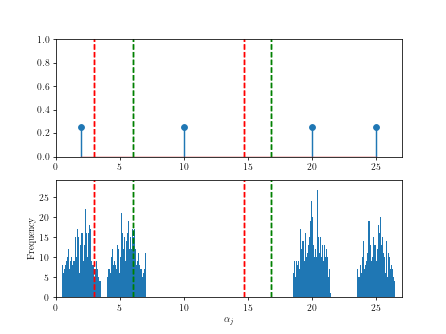

In [8]:
def compute_modal_distribution(alpha_pmf_val, size_vec):
    params = []
    i = 0
    mode =  np.zeros([])
    for val in alpha_pmf_val:      
        if i == 0:
            mu = alpha_pmf_val[i]
            lower = mu - 1.5
            upper = mu + 1.5
            sigma = 1
            a = (lower - mu)/sigma
            b = (upper - mu)/sigma
        else:
            mu = alpha_pmf_val[i]
            lower = mu - 1.5  
            upper =  mu + 1.5
            sigma = 1
            a = (lower - mu)/sigma
            b = (upper - mu)/sigma
        params.append((a,b,mu,sigma))  
        
        mode = np.append(truncnorm.rvs(a, b, size=size_vec[i], loc = mu, scale = sigma), mode)
        i += 1
        
    return mode, params


size = [2500, 2500,2500,2500]
samples_bimodal, mode_params = compute_modal_distribution(alpha_pmf_val, size)
samples_bimodal = samples_bimodal [:-1]

# for i in range(len(mode_params)):
#     fig,ax = plt.subplots(1,1)
#     a,b,mu, sigma = mode_params[i]
#     x = np.linspace(truncnorm.ppf(0.01, a, b, loc=mu,scale=sigma), 
#                     truncnorm.ppf(0.99, a, b, loc=mu,scale=sigma), 100)
#     y = truncnorm.pdf(x, a, b,loc=mu, scale=sigma)
#     np.savetxt("pmf" + str(i) + ".txt", np.c_[x,y]) 
#     plt.plot(x, y,'r-', lw=5, alpha=0.6, label='truncnorm pdf')
#     plt.show()
    
# Make Distribution Plots
fig, ax = plt.subplots(2,1)
ax[0].stem(alpha_pmf_val_est, alpha_pmf_wt_est)
ax[0].set_ylim([0,1])
for i in range(0,2): # Loop through number of pricing sets
    for j in range(0, len(int_bds_A[i])):
        ax[0].axvline(int_bds_A[i][j], color='r',linestyle='--')
        
    for j in range(0, len(int_bds_B[i])):
        ax[0].axvline(int_bds_B[i][j], color='g',linestyle='--')
        

ax[1].hist(samples_bimodal, bins=2000)
for i in range(0,2): # Loop through number of pricing sets
    for j in range(0, len(int_bds_A[i])):
        ax[1].axvline(int_bds_A[i][j], color='r',linestyle='--')
        
    for j in range(0, len(int_bds_B[i])):
        ax[1].axvline(int_bds_B[i][j], color='g',linestyle='--')
        
# ax[1].set_title(r"Bi-Modal Distribution of User $\alpha_j$ Values")
ax[1].set_xlabel(r"$\alpha_j$")
ax[1].set_ylabel(r"Frequency")

ax[0].set_xlim([0,27])
ax[1].set_xlim([0,27])

plt.show()


## Code for gradient plots below

In [10]:
# def surf_plot_diff_expect_eta_vary_p(delVdelR, alpha_pmf_val, R_ell, V_ell):
#     p_ = np.arange(0,1, .01)
#     p_tilde = np.arange(0,1,.01)
#     P, P_tilde = np.meshgrid(p_, p_tilde)
#     diff_E = np.zeros_like(P)
    
#     for i in range(0, P.shape[0]):
#         for j in range(0, P_tilde.shape[0]):  
#             choice_prob = prob_choice(delVdelR, alpha_pmf_val,[P[i][j], 1 - P[i][j]]
#                                      ,R_ell, V_ell)
#             choice_prob_tilde = prob_choice(delVdelR, alpha_pmf_val,[P_tilde[i][j], 1 - P_tilde[i][j]]
#                                            ,R_ell, V_ell)
            
#             exp_1_r = compute_exp_1_r(choice_prob, R_ell)
#             exp_1_r_tilde = compute_exp_1_r(choice_prob_tilde, R_ell)
            
# #             diff_E[i][j] = lambda_val*E_x*(exp_1_r - exp_1_r_tilde)/(lambda_val*E_x*exp_1_r)
#             diff_E[i][j] = lambda_val*E_x*(exp_1_r - exp_1_r_tilde)

#     print(diff_E.min(), diff_E.max())
#     # Plot gradient map of absolute value of the difference 
#     fig,ax = plt.subplots()
#     im1 = ax.imshow(diff_E,  vmin=diff_E.min(), vmax=diff_E.max(),
#                aspect='auto', extent=[0,1.0,1.0, 0])
#     ax.set_xlabel(r'$\tilde{p}_1$')
#     ax.set_ylabel(r'$p_1$')

#     cbar = fig.colorbar(im1)
#     cbar.ax.set_ylabel(r'$\mathbb{E}[\eta(t);p,a] - \mathbb{E}[\eta(t); \tilde{p}, \tilde{a}]$',
#                        rotation=270, labelpad = 25)
# #     cbar.set_ticks([-1, -0.8, -0.6, -0.4, -0.2, 0, .2, .4])
# #     cbar.set_ticklabels(["-100%", "-80%","-60%",'-40%','-20%','0%','20%','40%'])
# #     cbar.ax.set_ylabel(r'Percentage Error',
# #                        rotation=270, labelpad = 25)
#     plt.rcParams.update({'font.size': 16})    
#     plt.show()
# #     fig.savefig("./plots/proposition_p_var.pdf", bbox_inches='tight')

#     return diff_E

In [11]:
# surf_val_A = surf_plot_diff_expect_eta_vary_p(delVdelR_A, alpha_pmf_val_A, R_ell_A, V_ell_A)
# surf_val_B = surf_plot_diff_expect_eta_vary_p(delVdelR_B, alpha_pmf_val_B, R_ell_B, V_ell_B)

Now instead supposed that $p = \tilde{p}$ and $a$ is mischaracterized to be $\tilde{a}$. Take $p$ to be as defined in one of the previous blocks and assume that $a_2 = \tilde{a}_2$. Then we can plot the variability of $|\mathbb{E}[\eta(t);p,a] - \mathbb{E}[\eta(t); \tilde{p}, \tilde{a}]|$ with respect to $a_1$ and $\tilde{a}_1$. 

In [12]:
# def surf_plot_diff_expect_eta_vary_a(delVdelR, alpha_pmf_wt, R_ell, V_ell):
# #     a_ = np.arange(0,3, .1)
# #     a_tilde = np.arange(3, 16,.1)
#     a1_max = 15
#     a2_max = 30
#     a_ = np.linspace(0,a1_max,100)
#     a_tilde = np.linspace(0,a1_max, 100)
#     A, A_tilde = np.meshgrid(a_, a_tilde)
#     diff_E = np.zeros_like(A)
    
#     for i in range(0, A.shape[0]):
#         for j in range(0, A_tilde.shape[0]):  
#             choice_prob = prob_choice(delVdelR, [A[i][j], a2_max], alpha_pmf_wt
#                                      , R_ell, V_ell)
#             choice_prob_tilde = prob_choice(delVdelR, [A_tilde[i][j], a2_max], alpha_pmf_wt
#                                             , R_ell, V_ell)
            
#             exp_1_r = compute_exp_1_r(choice_prob, R_ell)
#             exp_1_r_tilde = compute_exp_1_r(choice_prob_tilde, R_ell)
            
#             diff_E[i][j] = lambda_val*E_x*(exp_1_r - exp_1_r_tilde)/(lambda_val*E_x*(exp_1_r))
            
 
#     # Plot gradient map of absolute value of the difference 
#     fig,ax = plt.subplots()
#     im1 = ax.imshow(diff_E,  vmin=diff_E.min(), vmax=diff_E.max(),
#                aspect='auto', extent=[0, a1_max, a1_max, 0])
#     ax.set_xlabel(r'$a_1$')
#     ax.set_ylabel(r'$\tilde{a}_1$')

#     cbar = fig.colorbar(im1)
#     cbar.ax.set_ylabel(r'$\mathbb{E}[\eta(t);p,a] - \mathbb{E}[\eta(t); \tilde{p}, \tilde{a}]$',
#                        rotation=270, labelpad = 25)
#     plt.rcParams.update({'font.size': 16})    
#     plt.show()
# #     fig.savefig("./plots/proposition_a_var.pdf", bbox_inches='tight')  
    
#     return diff_E

In [13]:
# surf_val_A = surf_plot_diff_expect_eta_vary_a(delVdelR_A, alpha_pmf_wt_A, R_ell_A, V_ell_A)
# surf_val_B = surf_plot_diff_expect_eta_vary_a(delVdelR_B, alpha_pmf_wt_B, R_ell_B, V_ell_B)

**Note that the two plots above either assume that either $\tilde{a} = a$ and $p \neq \tilde{p}$ OR $\tilde{a}_i = a_i$ for some $i$, $\tilde{a}_j \neq a_j$ for all $j \neq i$, and $p = \tilde{p}$. However, the bound holds for the case when $p_i \neq \tilde{p}_i$ and $a_i \neq \tilde{a}_i$ for all $i$. The aforementioned constraints are only introduced for ease of illustraton.**

Next, we illustrate the variation of $\mathbb{E}[\eta(t);p,a]$. 

In [14]:
# ps=np.arange(0,1.1,0.01)
# prob_choosing_R = {key:value for (key,value) in zip(ps,[prob_choice(delVdelR, alpha_pmf_val, [p,1-p]) for p in ps])}

In [15]:
# E_1_r={}
# E_eta={}
# for p in ps:
#     E_1_r[p] = 0
#     for i in range(0, R_ell.size):
#         E_1_r[p] += prob_choosing_R[p][i] * (1/R_ell[i])
#     E_eta[p] = lambda_val*E_x*E_1_r[p]

# max_diff_E = lambda_val * E_x * (1/np.min(R_ell) - 1/np.max(R_ell))
# print("\tMax E[eta] - E[eta_true]:", max_diff_E)

In [16]:
# %matplotlib inline

# to_plot=[[p,E[0]] for (p,E) in E_eta.items()]
# to_plot=np.array(to_plot)
# fig, axes = plt.subplots()

# axes.plot(to_plot[:,0],to_plot[:,1],color='green')
# axes.set_xlabel(r'$p$')
# axes.set_ylabel(r'$\mathbb{E}[\eta(t);p,a]$')
# # axes.set_title(r'$a=[%d, %d]$, $Prob(\alpha_j = a_1)=p$' %(alpha_pmf_val[0],alpha_pmf_val[1]))
# plt.rcParams.update({'font.size': 16})    
# plt.show()
# fig.savefig("./plots/theorem_grad_p.pdf", bbox_inches='tight')  

In [17]:
# alpha_lows=np.arange(0.5,8,.1)
# alpha_highs=np.arange(8,20,.1)
# alphas=[[alpha_low,alpha_high] for alpha_low in alpha_lows for alpha_high in alpha_highs]
# prob_choosing_Ra = list(zip(alphas,[prob_choice(delVdelR, alpha_pair, alpha_pmf_wt) for alpha_pair in alphas]))

In [18]:
# E_etaa=[]
# for (alpha_pair,probs) in prob_choosing_Ra:
#     E_1_r_temp=0;
#     for i in range(0, R_ell.size):
#         E_1_r_temp += probs[i] * (1/R_ell[i])
#     E_eta_temp= lambda_val*E_x*E_1_r_temp
#     E_etaa.append(np.hstack((alpha_pair,E_eta_temp)))
# E_etaa=np.array(E_etaa)

In [19]:
# %matplotlib notebook
# fig = plt.figure()
# ax = fig.add_subplot(1, 1, 1, projection='3d')
# ax.plot_trisurf(E_etaa[:,0],E_etaa[:,1],E_etaa[:,2])
# ax.set_xlabel(r'$a_1$')
# ax.set_ylabel(r'$a_2$')
# ax.set_zlabel(r'$\mathbb{E}[\eta(t); p,a]$')
# # ax.set_title(r'$[p_{low},p_{high}]=[%2.1f, %2.1f]$' % (alpha_pmf_wt[0],alpha_pmf_wt[1]))

# plt.rcParams.update({'font.size': 16})    
# plt.show()
# fig.savefig("./plots/theorem_grad_a.pdf", bbox_inches='tight') 